In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split

In [3]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

/content/drive/MyDrive/project3


In [4]:

def load_image(datadir,img_new_size, pic_new_cnt) :

  food_middle_list = sorted(os.listdir(datadir)) # 중분류
  food_list = [] # 음식이름
  food_path_list = [] # 음식이름 경로

  for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

  image_li, target_li, except_li = load_and_resize_images(food_path_list, food_list, img_size = img_new_size, pic_cnt = pic_new_cnt)

  return image_li, target_li, except_li

image_dir = '/content/drive/MyDrive/project3/data/traindata/selected_image_color'
image_li, target_li, except_li = load_image(image_dir,(224,224),900)

Processing images: 100%|██████████| 6/6 [12:11<00:00, 121.88s/it]


In [5]:
# food_class 수
print(np.unique(target_li))
target_class_cnt = np.unique(target_li).shape[0]
print(target_class_cnt)

['갈비구이' '곱창구이' '라면' '열무국수' '열무김치' '황태구이']
6


In [6]:
print(image_li.shape)
print(target_li.shape)
print(except_li)

(5381, 224, 224, 3)
(5381,)
[]


In [7]:
image_li[2].shape

(224, 224, 3)

(224, 224, 3)
라면


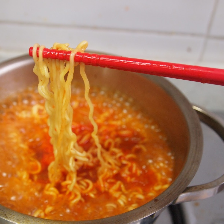

In [8]:
pic_num = 10
print(image_li[pic_num].shape)
print(target_li[pic_num])
cv2_imshow(image_li[pic_num])

In [9]:
target_li

array(['황태구이', '라면', '황태구이', ..., '라면', '라면', '라면'],
      dtype='<U10')

In [10]:
def preprocessing_image(image_list, target_list):

  # 카테고리랑 숫자로 바꾼 값 dict형태로 만들기
  categories_label = {category:i for i, category in enumerate(np.unique(target_list))}
  # target값을 숫자로 변형
  target_num = np.array([categories_label[category] for category in target_list], dtype=np.int8)

  X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42 )

  # 정규화
  X_train = X_train / 255.0
  X_test = X_test / 255.0

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocessing_image(image_li, target_li)

In [11]:
y_test

array([5, 1, 1, ..., 4, 3, 4], dtype=int8)

In [12]:
def VGG16(input_shape):
# VGG16 모델
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=input_shape),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(target_class_cnt, activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [13]:
model = VGG16(input_shape = (224,224,3))
history = model.fit(X_train,y_train,epochs = 100,validation_split = 0.2)

Epoch 1/100
108/108 [==============================] - 62s 400ms/step - loss: 2.4804 - accuracy: 0.1580 - val_loss: 1.7920 - val_accuracy: 0.1626
Epoch 2/100
108/108 [==============================] - 31s 292ms/step - loss: 1.7921 - accuracy: 0.1714 - val_loss: 1.7922 - val_accuracy: 0.1626
Epoch 3/100
108/108 [==============================] - 32s 293ms/step - loss: 1.7919 - accuracy: 0.1647 - val_loss: 1.7926 - val_accuracy: 0.1603
Epoch 4/100
108/108 [==============================] - 31s 291ms/step - loss: 1.7918 - accuracy: 0.1656 - val_loss: 1.7926 - val_accuracy: 0.1626
Epoch 5/100
108/108 [==============================] - 31s 292ms/step - loss: 1.7917 - accuracy: 0.1714 - val_loss: 1.7926 - val_accuracy: 0.1626
Epoch 6/100
108/108 [==============================] - 32s 293ms/step - loss: 1.7918 - accuracy: 0.1714 - val_loss: 1.7924 - val_accuracy: 0.1626
Epoch 7/100
108/108 [==============================] - 32s 292ms/step - loss: 1.7918 - accuracy: 0.1714 - val_loss: 1.7926 -

KeyboardInterrupt: 